# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему мы сделали выбор в пользу VGGFace2?**

**ВПИШИТЕ ОТВЕТ ЗДЕСЬ**

**-----**
Данный датасет построен на базе 3,3 млн изображений, а значит обучение сети производилось на очень больших данных, что говорит о предполагаемом качестве обучения. Учитывая большое количество (9000) персоналий и количество образцов изображений на каждую персоналию, а также общую направленность датасета и нашей задачи, можно предположить, что внутри сети скрыто много специфических признаков, позволяющих решить столь сложную задачу, как определение пола, возраста и расы по фото.


*Возможный ответ: Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам горазддо полезне и помогут обучить модель лучше и быстрее*

**-----**




А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-z8umknql
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-z8umknql
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=8965b085e4c03a04629c40bafb67315861ac672a5ecf7556648cf713a1ece1a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-hd427e3w/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [ ]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально

from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

Using TensorFlow backend.


165445632/165439116 [==============================] - 5s 0us/step


Ошибка появляется потому что, пример из репозитория не использует режим eager_execution, который мы всегда включали в своих примерах для удобства разработки и соответствия новым стандартам tensorflow. 

Но это не проблема. Мы за вас заранее выполнили код выше без eager_execution и сохранили модель с помощью save_model. Она находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:


In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:01, 128MB/s]


'resnet50face.h5'

In [ ]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [ ]:
vggface.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [ ]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2020-07-14 10:16:17--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.26.0.209, 172.67.75.181, 104.26.1.209, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.26.0.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41762 (41K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  40.78K  --.-KB/s    in 0s      

2020-07-14 10:16:17 (96.4 MB/s) - ‘brad_pitt.jpg’ saved [41762/41762]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


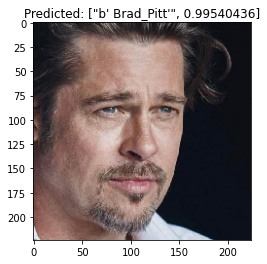

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!
# plt.imshow(x)
# plt.show()
preds = vggface.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:01, 60.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 91.2MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['5_0_1_20170110213654372.jpg.chip.jpg', '3_0_0_20170110212707387.jpg.chip.jpg', '60_1_0_20170110131522551.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,3_1_0_20170109193452700.jpg.chip.jpg,0.025862,0,1
1,2_1_2_20161219195813835.jpg.chip.jpg,0.017241,2,1
2,26_0_3_20170104230509745.jpg.chip.jpg,0.224138,3,0
3,11_1_0_20170109205247087.jpg.chip.jpg,0.094828,0,1
4,40_0_3_20170116030108440.jpg.chip.jpg,0.344828,3,0


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

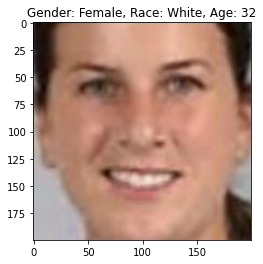

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


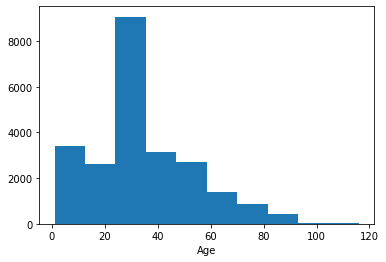

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Предподготовка закончена. А теперь ваша очередь:) Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы предлагаем вам воспользоваться `tensorflow.keras.preprocessing.image.ImageDataGenerator`

###a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image):
    """
    image -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    from keras_vggface import utils
    
    preprocessed = utils.preprocess_input(image, version=2) 
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

###b)

Для генерации картинок раньше мы использовали `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому вы должны воспользоваться более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 256
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col="img_name",
    y_col="gender",
    directory=str(data_folder),
    class_mode = "binary",
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE,
    shuffle=True)
val_generator = image_gen.flow_from_dataframe(
    dataframe = df_val,
    x_col="img_name",
    y_col="gender",
    directory=str(data_folder),
    class_mode = "binary",
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE,
    shuffle=False)

# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [ ]:
next(val_generator)[0].shape

(128, 256, 256, 3)

In [ ]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


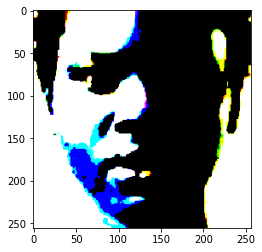

In [ ]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [ ]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

163.5047 -131.0912


###с)
**Реализуйте функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

Female


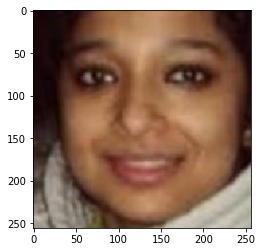

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    image = np.copy(vggface_image)   
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912

    image = image[..., ::-1]
    image = image/255
    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##Здание 3. Обучение модели предсказания пола

В этом задании вы должны обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"
*   Рекомендуется в model.fit(...) использовать steps_per_epoch=25, для того чтобы проверка на валидации происходила чаще и вы могли более точно отслеживать прогресс. Полная эпоха ~140 итераций.
*   За точность выше 94% -- дополнительные баллы.



In [ ]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
# < YOUR CODE STARTS HERE >
base_model.trainable = False
len(base_model.layers)

175

In [ ]:
base_model.trainable = True
fine_tune_at = 170
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model_gender = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model_gender.add(tf.keras.layers.Dense(1, activation="sigmoid"))
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 

model_gender.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 
model_gender.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 6,145
Non-trainable params: 23,557,056
_________________________________________________________________


In [ ]:
history = model_gender.fit(train_generator,
                           steps_per_epoch=25,
                           epochs=20,
                           validation_data=val_generator)
                           

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
25/25 [==============================] - 21s 820ms/step - loss: 0.6860 - accuracy: 0.7337 - val_loss: 0.3597 - val_accuracy: 0.8674
Epoch 2/20
25/25 [==============================] - 19s 765ms/step - loss: 0.2559 - accuracy: 0.9081 - val_loss: 0.2716 - val_accuracy: 0.9040
Epoch 3/20
25/25 [==============================] - 19s 770ms/step - loss: 0.2308 - accuracy: 0.9187 - val_loss: 0.2489 - val_accuracy: 0.9141
Epoch 4/20
25/25 [==============================] - 19s 777ms/step - loss: 0.2080 - accuracy: 0.9288 - val_loss: 0.2291 - val_accuracy: 0.9212
Epoch 5/20
25/25 [==============================] - 19s 765ms/step - loss: 0.2033 - accuracy: 0.9266 - val_loss: 0.2140 - val_accuracy: 0.9241
Epoch 6/20
25/25 [==============================] - 19s 755ms/step - loss: 0.2095 - accuracy: 0.9306 - val_loss: 0.2082 - val_accuracy: 0.9273
Epoch 7/20
25/25 [==============================] - 19s 754ms/step

In [ ]:
base_model.trainable = True
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [ ]:
model_gender.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-6), loss= tf.keras.losses.BinaryCrossentropy(from_logits=False) , metrics=["accuracy"]) 

history = model_gender.fit_generator(train_generator,
                          #  steps_per_epoch=25,
                           epochs=10,
                           validation_data=val_generator)
                           

Epoch 1/10
149/149 [==============================] - 66s 446ms/step - loss: 0.1703 - accuracy: 0.9406 - val_loss: 0.1885 - val_accuracy: 0.9311
Epoch 2/10
 17/149 [==>...........................] - ETA: 45s - loss: 0.1369 - accuracy: 0.9522

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(model_gender,"checkpoint_best.h5")
# < YOUR CODE ENDS HERE >

In [ ]:
model_gender = load_model("checkpoint_best.h5")
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 12s 308ms/step - loss: 0.1878 - accuracy: 0.9328
Very good! Can you improve accuracy?


In [ ]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

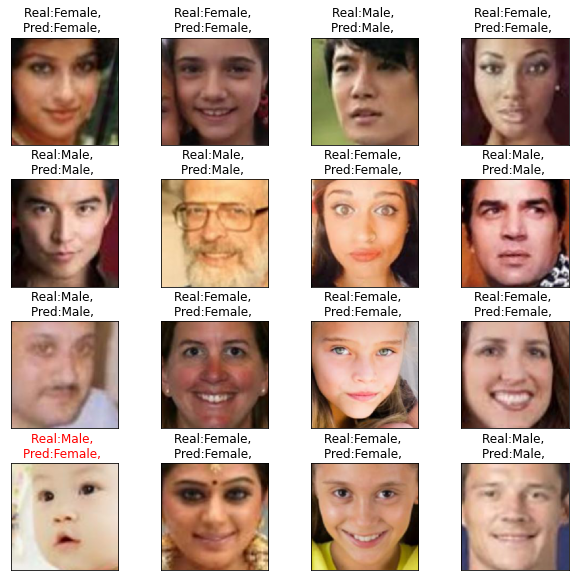

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Здание 4. Обучение модели предсказания расы

В этом задании вы должны обучить модель предсказания расы с точностью более 80% на валидационном сете. 

*   Используя код аналогичный тому, что выше, реализуйте модель предсказания расы
*   Для начала определите генератор данных
    *  нужно указать class_mode="sparse" и изменить "y_col"
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_race/checkpoint_best.h5"
*   За точность выше 85% -- дополнительные баллы.



In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False
len(base_model.layers)

175

In [ ]:

df_train['age'] = df_train['age'].astype('float',errors='ignore',copy=False)
df_train['race'] = df_train['race'].astype('float',errors='ignore',copy=False)
df_train['gender'] = df_train['gender'].astype('float',errors='ignore',copy=False)
df_val['age'] = df_val['age'].astype('float',errors='ignore',copy=False)
df_val['race'] = df_val['race'].astype('float',errors='ignore',copy=False)
df_val['gender'] = df_val['gender'].astype('float',errors='ignore',copy=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# < YOUR CODE STARTS HERE >
train_generator = image_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col="img_name",
    y_col="race",
    directory=str(data_folder),
    class_mode = "other",
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE,
    shuffle=True)
val_generator = image_gen.flow_from_dataframe(
    dataframe = df_val,
    x_col="img_name",
    y_col="race",
    directory=str(data_folder),
    class_mode = "other",
    batch_size = BATCH_SIZE, 
    image_size = IMAGE_SIZE,
    shuffle=False)


Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [ ]:
# Обучение модели предсказания расы
# base_model.trainable = True
# fine_tune_at = 170
# # все слои до -- заморозим
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False
# base_model.summary()

model_race = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-3) 
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

model_race.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 

history = model_race.fit(train_generator,
                           steps_per_epoch=25,
                           epochs=30,
                           validation_data=val_generator)
                        

Epoch 1/30
25/25 [==============================] - 19s 770ms/step - loss: 1.6490 - accuracy: 0.6155 - val_loss: 0.8598 - val_accuracy: 0.8075
Epoch 2/30
25/25 [==============================] - 19s 741ms/step - loss: 0.7557 - accuracy: 0.8275 - val_loss: 0.7288 - val_accuracy: 0.8403
Epoch 3/30
25/25 [==============================] - 19s 749ms/step - loss: 0.6785 - accuracy: 0.8344 - val_loss: 0.6986 - val_accuracy: 0.8357
Epoch 4/30
25/25 [==============================] - 18s 738ms/step - loss: 0.5575 - accuracy: 0.8612 - val_loss: 0.6679 - val_accuracy: 0.8428
Epoch 5/30
25/25 [==============================] - 19s 743ms/step - loss: 0.5773 - accuracy: 0.8547 - val_loss: 0.6791 - val_accuracy: 0.8334
Epoch 6/30
25/25 [==============================] - 19s 753ms/step - loss: 0.5875 - accuracy: 0.8559 - val_loss: 0.6514 - val_accuracy: 0.8453
Epoch 7/30
25/25 [==============================] - 18s 723ms/step - loss: 0.5369 - accuracy: 0.8528 - val_loss: 0.6322 - val_accuracy: 0.8405

In [ ]:
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 

model_race.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), loss= loss , metrics=["accuracy"]) 

history = model_race.fit(train_generator,
                           epochs=10,
                           validation_data=val_generator)

tf.keras.models.save_model(model_race,"model_race_checkpoint_best.h5")                           
# < YOUR CODE ENDS HERE >

Epoch 1/10
149/149 [==============================] - 55s 368ms/step - loss: 0.3146 - accuracy: 0.8997 - val_loss: 0.5426 - val_accuracy: 0.8561
Epoch 2/10
149/149 [==============================] - 54s 361ms/step - loss: 0.3062 - accuracy: 0.9017 - val_loss: 0.5384 - val_accuracy: 0.8554
Epoch 3/10
149/149 [==============================] - 54s 363ms/step - loss: 0.3018 - accuracy: 0.9029 - val_loss: 0.5347 - val_accuracy: 0.8569
Epoch 4/10
149/149 [==============================] - 53s 358ms/step - loss: 0.2985 - accuracy: 0.9037 - val_loss: 0.5335 - val_accuracy: 0.8559
Epoch 5/10
149/149 [==============================] - 53s 356ms/step - loss: 0.2958 - accuracy: 0.9046 - val_loss: 0.5319 - val_accuracy: 0.8565
Epoch 6/10
149/149 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9058

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(model_race,"model_race_checkpoint_best.h5")

In [ ]:
model_race = load_model("model_race_checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 11s 279ms/step - loss: 0.5297 - accuracy: 0.8571
Well done!


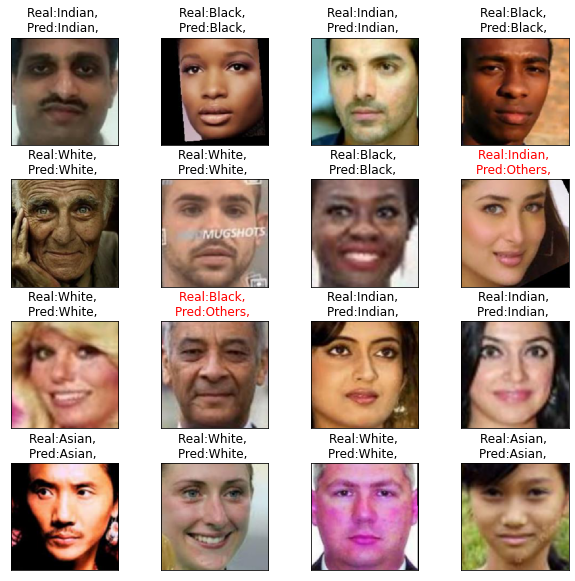

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_4 (Model)              (None, 2048)              23561152  
_________________________________________________________________
race (Dense)                 (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


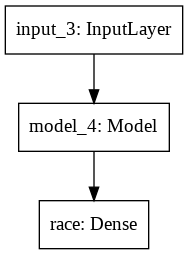

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

IMAGE_SIZE = 224
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# < YOUR CODE STARTS HERE >
# переменная model должна содержать модель для дальнейшего обучения
base_model_layer = base_model(input_layer)
# input_layer = base_model
# , activation='sigmoid'
additional_layer0 = tf.keras.layers.Dense(10,name = 'additional_layer0')(base_model_layer)
additional_layer1 = tf.keras.layers.Dense(10,name = 'additional_layer1')(additional_layer0)

output_gender = tf.keras.layers.Dense(1, activation='sigmoid',name = 'gender')(additional_layer1)
output_race = tf.keras.layers.Dense(5, activation='softmax',name = 'race')(base_model_layer)
output_age = tf.keras.layers.Dense(1, activation='sigmoid',name = 'age')(additional_layer1)

# model = tf.keras.Model(
#   inputs = input_layer,
#   outputs = [output_race])



model = tf.keras.Model(
  inputs = input_layer,
  # outputs = [output_gender,output_race,output_age]
  outputs = [output_race]
  )

# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


Shape tests passed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,img_name,age,race,gender,is_train
0,3_1_0_20170109193452700.jpg.chip.jpg,0.025862,0.0,1.0,1
1,2_1_2_20161219195813835.jpg.chip.jpg,0.017241,2.0,1.0,1
2,26_0_3_20170104230509745.jpg.chip.jpg,0.224138,3.0,0.0,1
3,11_1_0_20170109205247087.jpg.chip.jpg,0.094828,0.0,1.0,1
4,40_0_3_20170116030108440.jpg.chip.jpg,0.344828,3.0,0.0,1
...,...,...,...,...,...
23700,31_1_1_20170116173451354.jpg.chip.jpg,0.267241,1.0,1.0,1
23701,88_1_0_20170120230330380.jpg.chip.jpg,0.758621,0.0,1.0,1
23702,58_0_3_20170119195320690.jpg.chip.jpg,0.500000,3.0,0.0,1
23703,34_0_0_20170117182731575.jpg.chip.jpg,0.293103,0.0,0.0,1


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


А теперь перейдем к обучению:

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4) # вы можете выбрать другую скорость обучения для вашей модели

model.compile(optimizer=optimizer, 
              loss={'race': tf.keras.losses.SparseCategoricalCrossentropy()},
              metrics={'race': 'accuracy'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_path = "model_multitask_checkpoint_best.h5"
# cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

model.fit((train_generator), epochs=15, validation_data=(val_generator),
                    # callbacks=[PlotLossesCallback(), checkpoint], 
                    steps_per_epoch=50, 
                    validation_steps= (len(df_val) // BATCH_SIZE)
                    )

Epoch 1/15
50/50 [==============================] - 27s 532ms/step - loss: 3.1627 - accuracy: 0.3339 - val_loss: 2.1738 - val_accuracy: 0.4521
Epoch 2/15
50/50 [==============================] - 26s 513ms/step - loss: 1.7748 - accuracy: 0.5327 - val_loss: 1.3722 - val_accuracy: 0.6212
Epoch 3/15
50/50 [==============================] - 26s 521ms/step - loss: 1.1912 - accuracy: 0.6766 - val_loss: 1.0363 - val_accuracy: 0.7194
Epoch 4/15
50/50 [==============================] - 27s 531ms/step - loss: 0.9602 - accuracy: 0.7444 - val_loss: 0.8815 - val_accuracy: 0.7620
Epoch 5/15
50/50 [==============================] - 26s 517ms/step - loss: 0.8619 - accuracy: 0.7730 - val_loss: 0.7900 - val_accuracy: 0.7908
Epoch 6/15
50/50 [==============================] - 26s 523ms/step - loss: 0.7789 - accuracy: 0.7942 - val_loss: 0.7381 - val_accuracy: 0.8043
Epoch 7/15
50/50 [==============================] - 26s 516ms/step - loss: 0.7591 - accuracy: 0.8033 - val_loss: 0.6944 - val_accuracy: 0.8188

In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])
# InvalidArgumentError:  Incompatible shapes: [128,1] vs. [3,128]
    Для такого превращения и нужна эта функция.

    """
    # np.array(*your list*, dtype=np.float)
    while True:
        data = (next(generator))
        image = data[0]
        labels = (np.split(data[1], 3, axis=1))
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [ ]:

model = tf.keras.Model(
  inputs = input_layer,
  outputs = [output_gender,output_race,output_age]
  )

# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)
optimizer = tf.keras.optimizers.Adam(lr=1e-3) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': tf.keras.losses.SparseCategoricalCrossentropy(), 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_path = "model_multitask_checkpoint_best.h5"
# cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

model.fit(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    # callbacks=[PlotLossesCallback(), checkpoint], 
                    steps_per_epoch=50, 
                    validation_steps= (len(df_val) // BATCH_SIZE)
                    )

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2048)         23561152    input_3[0][0]                    
__________________________________________________________________________________________________
additional_layer0 (Dense)       (None, 10)           20490       model_4[1][0]                    
__________________________________________________________________________________________________
additional_layer1 (Dense)       (None, 10)           110         additional_layer0[0][0]          
____________________________________________________________________________________________

In [ ]:
tf.keras.models.save_model(model,"model_multitask_checkpoint_best.h5") 

In [ ]:
model_multitask = load_model("model_multitask_checkpoint_best.h5")
# val_generator = image_gen.flow_from_dataframe(
#         dataframe=df_val,
#         class_mode="other",
#         x_col="img_name", y_col=["gender", "race", "age"], 
#         directory=str(data_folder),
#         target_size=(IMAGE_SIZE, IMAGE_SIZE),
#         batch_size=BATCH_SIZE,
#         shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
# assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

37/37 [==============================] - 9s 247ms/step - loss: 0.7073 - gender_loss: 0.1507 - race_loss: 0.5524 - age_loss: 0.0041 - gender_accuracy: 0.9406 - race_accuracy: 0.4152 - age_mae: 0.0475
Well done!


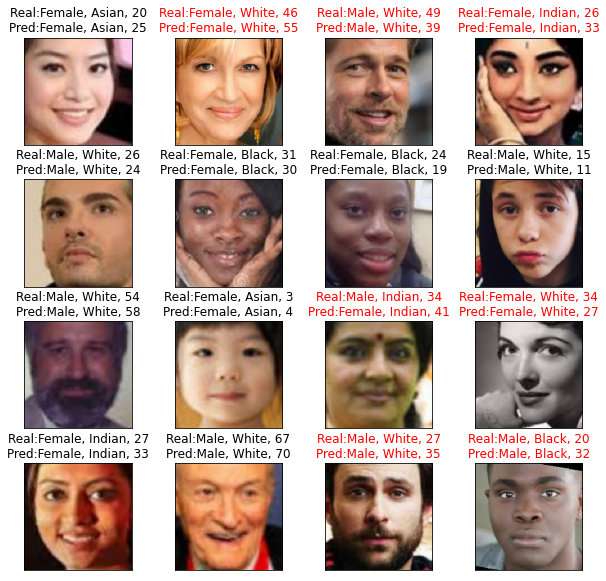

In [149]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /content/me.jpg
2.34MB [00:00, 158MB/s]


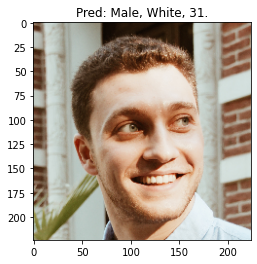

In [ ]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# я получился немного моложе :)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


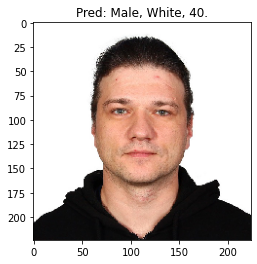

In [150]:
from google.colab import drive
drive.mount('/content/drive/')

# !ls "/content/drive/My Drive/"

img = image.load_img("//content//drive//My Drive//Colab Notebooks//HDJS9044.jpg",target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)

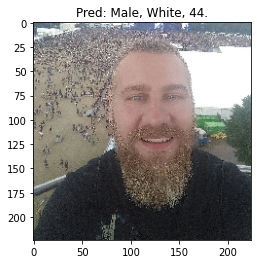

In [156]:

img = image.load_img("//content//drive//My Drive//Colab Notebooks//IMG_8391.JPG",target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)

#Заключение 

Это было очень сложное и важное домашнее задание. Надеемся, вы с ним справились успешно и готовы к переходу к следующему модулю! Удачи!